In [268]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [346]:
import pandas as pd
import itertools
from collections import namedtuple
from plotnine import *
from multiprocessing import Pool
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [347]:
n_splits = 8
animals = pd.read_csv('animals.csv')
animals.drop("ImputatedSex", inplace=True, axis=1)
animals = animals.rename(columns = {'Unnamed: 0':'ID'})

In [348]:
animals.Hair = pd.Categorical(animals.Hair).codes # NaN becomes -1
animals.loc[animals.Hair == -1, 'Hair'] = np.nan
cols = [0] + range(11,39)
cats = animals[animals.AnimalType=='Cat'].iloc[:,cols]
dogs = animals[animals.AnimalType=='Dog'].iloc[:,cols]

Fix the NaN values for cats and dogs seperately because we have some different columns for each and don't want to impute values using the median from the other animal type.

In [349]:
# pd.isnull(cats).sum() > 0

In [350]:
# imputer = Imputer(strategy='median', axis=0)   

# for cats set values taht make sense for these (i.e. 1-5 scale: choose 3)
cats.iloc[:, 10:26] = 5
cats['Avg Weight (pounds)'] = 9
cats['Avg Height (inches)'] = 9
cats['Avg Age'] = 12
dogs.Hair = 2

In [351]:
dogs.fillna(dogs.median(), axis=0, inplace=True)
cats.fillna(cats.median(), axis=0, inplace=True)

outcomes = pd.DataFrame(animals.iloc[:, [0, 4]])
animals = pd.concat([dogs, cats])
animals = pd.merge(animals, outcomes, on='ID')
animals.columns = [x.replace('_y', '') for x in animals.columns]

[(i, x) for i, x in enumerate(animals.columns)]
# pd.isnull(animals).sum() > 0

[(0, 'ID'),
 (1, 'HasName'),
 (2, 'AgeinDays'),
 (3, 'Hour'),
 (4, 'Weekday'),
 (5, 'Month'),
 (6, 'WeekofYear'),
 (7, 'isHoliday'),
 (8, 'type'),
 (9, 'TransformedSex'),
 (10, 'Protects Property'),
 (11, 'Hunts & Chases'),
 (12, 'Less Likely to Wander'),
 (13, 'Loving'),
 (14, 'Child-Friendly'),
 (15, 'Dog-Friendly'),
 (16, 'Pet-Friendly'),
 (17, 'Stranger-Friendly'),
 (18, 'Avg Height (inches)'),
 (19, 'Avg Weight (pounds)'),
 (20, 'Size Score (1 to 5)'),
 (21, 'Avg Age'),
 (22, 'Fewer Health Issues'),
 (23, 'Energetic'),
 (24, 'Intelligent'),
 (25, 'Easy to Train'),
 (26, 'IsMix'),
 (27, 'Hair'),
 (28, 'IsMultiColor'),
 (29, 'OutcomeType')]

In [352]:
def stage(x):
    if x <= 28:
        return 'NewBorn'
    elif x > 28 and x <= 35:
        return '1MoSpike'
    elif x > 35 and x <= 60:
        return '2MoSpike'
    elif x > 60 and x < 365:
        return 'KittenPuppy'
    elif x >= 365 and x < 10 * 365:
        return 'Adult'
    elif x >= 10 * 356:
        return 'OldAge'    

outcome_type = animals.pop('OutcomeType')
animals['Stage'] = animals.AgeinDays.map(stage)
animals.Stage = pd.Categorical(animals.Stage, categories=[
    'NewBorn', '1MoSpike', '2MoSpike', 'KittenPuppy', 'Adult', 'OldAge']).codes
animals['OutcomeType'] = outcome_type

animals.columns.tolist()

['ID',
 'HasName',
 'AgeinDays',
 'Hour',
 'Weekday',
 'Month',
 'WeekofYear',
 'isHoliday',
 'type',
 'TransformedSex',
 'Protects Property',
 'Hunts & Chases',
 'Less Likely to Wander',
 'Loving',
 'Child-Friendly',
 'Dog-Friendly',
 'Pet-Friendly',
 'Stranger-Friendly',
 'Avg Height (inches)',
 'Avg Weight (pounds)',
 'Size Score (1 to 5)',
 'Avg Age',
 'Fewer Health Issues',
 'Energetic',
 'Intelligent',
 'Easy to Train',
 'IsMix',
 'Hair',
 'IsMultiColor',
 'Stage',
 'OutcomeType']

In [353]:
def skf_generator(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    for train_index, test_index in skf.split(np.zeros(len(t)), t):
        yield train_index, test_index

def run_skf(data, n_splits):
    splits = [(data.iloc[train_index], data.iloc[test_index]) 
              for train_index, test_index in skf_generator(data, n_splits=n_splits)]
    return zip(*splits) # return seperate lists of train/test instead of one combined

In [354]:
def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .ID.rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

In [355]:
columns = ['ID',
 'HasName',
 'AgeinDays',
 'Hour',
 'Weekday',
 'Month',
 'WeekofYear',
 'isHoliday',
 'type',
 'TransformedSex',
 'Protects Property',
 'Hunts & Chases',
 'Less Likely to Wander',
 'Loving',
 'Child-Friendly',
 'Dog-Friendly',
 'Pet-Friendly',
 'Stranger-Friendly',
 'Avg Height (inches)',
 'Avg Weight (pounds)',
 'Size Score (1 to 5)',
 'Avg Age',
 'Fewer Health Issues',
 'Energetic',
 'Intelligent',
 'Easy to Train',
 'IsMix',
 'Hair',
 'IsMultiColor',
 'Stage',
 'OutcomeType']

data, validate = train_test_split(animals.loc[:, columns], test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(animals))
print 'Number of validation samples: {}'.format(len(validate))
train, test = run_skf(data, n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of validation samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8356,152,1204,3745,7330,20787
Fold 2,8356,152,1205,3745,7330,20788
Fold 3,8356,152,1205,3745,7331,20789
Fold 4,8356,152,1205,3745,7331,20789
Fold 5,8356,152,1205,3745,7331,20789
Fold 6,8356,152,1205,3745,7331,20789
Fold 7,8357,153,1205,3745,7331,20791
Fold 8,8357,153,1205,3745,7331,20791


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1194,22,173,535,1048,2972
Fold 2,1194,22,172,535,1048,2971
Fold 3,1194,22,172,535,1047,2970
Fold 4,1194,22,172,535,1047,2970
Fold 5,1194,22,172,535,1047,2970
Fold 6,1194,22,172,535,1047,2970
Fold 7,1193,21,172,535,1047,2968
Fold 8,1193,21,172,535,1047,2968


In [356]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)

In [357]:
def plot_results(X, t, target_names, loss, pred, n_splits, show_title=True):
    print('')
    if show_title:
        print('Fold {} of {}'.format(len(loss.train), n_splits))
        print('Train log loss: {}'.format(loss.train[-1]))
    print('Test log loss: {}'.format(loss.test[-1]))
    
    if show_title:
        title = 'Confusion Matrix for Fold {0} of {1}'.format(len(loss), n_splits)
    else:
        title = ""
    cm = confusion_matrix(t.test, pred.test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title=title)
    print(classification_report(t.test, pred.test, target_names=target_names))

In [358]:
def plot_importance(clf, X, t):
    print('Classifier score (accuracy): {}'.format(clf.score(X.test, t.test)))

    if not hasattr(clf, 'feature_importances_'):
        return
    # Print the feature ranking
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.train.shape[1]), X.train.columns[indices], rotation=90)
    plt.xlim([-1, X.train.shape[1]])
    plt.show()

In [359]:
def create_output(t_true, t_pred, target_names):
    k1 = pd.get_dummies(t_pred, columns=target_names)
    k1 = k1.reindex_axis(target_names, axis=1)
    k1.fillna(0, inplace=True)
    return k1

In [360]:
def calc_ln_loss(t_true, t_pred, target_names):
    return log_loss(pd.get_dummies(t_true, columns=target_names), 
                    create_output(t_true, t_pred, target_names))

In [361]:
def ln_loss_scorer(clf, X, t):
    pred = clf.predict(X)
    # Hack Notice: target_names not passed in, so it's global...
    return calc_ln_loss(t, pred, target_names)

In [362]:
def run_classifier(clf, X, t, target_names, loss):    
    clf.fit(X.train, t.train)
    pred = TrainTest(pd.Categorical(clf.predict(X.train), categories=target_names),
                     pd.Categorical(clf.predict(X.test), categories=target_names))
    
    loss.train.append(calc_ln_loss(t.train, pred.train, target_names))
    loss.test.append(calc_ln_loss(t.test, pred.test, target_names))
    
    return clf, pred, loss

In [363]:
TrainTest = namedtuple('TrainTest', 'train, test')
target_names = sort(animals.OutcomeType.unique())

In [364]:
def run_classifier_CV(clf, train, test, target_names, loss, plot=False):
    clfs = []
    for i in range(len(train)):
        this_clf = clone(clf)
        # ID is in first column, outcome is in Last
        X = TrainTest(train[i].iloc[:, 1:-1], test[i].iloc[:, 1:-1])
        t = TrainTest(pd.Categorical(train[i].OutcomeType, categories=target_names),
                      pd.Categorical(test[i].OutcomeType, categories=target_names))
        this_clf, pred, loss = run_classifier(this_clf, X, t, target_names, loss)
        if plot:
            plot_results(X, t, target_names, loss, pred, len(train))
            plot_importance(this_clf, X, t)
        clfs.append(this_clf)
    return clfs



Fold 1 of 8
Train log loss: 4.85839140707
Test log loss: 10.2152033819
                 precision    recall  f1-score   support

       Adoption       0.71      0.85      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.77      0.21      0.33       173
Return_to_owner       0.54      0.50      0.52       535
       Transfer       0.77      0.75      0.76      1048

    avg / total       0.70      0.70      0.69      2972

Classifier score (accuracy): 0.704239569314


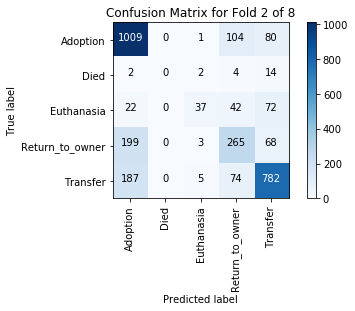

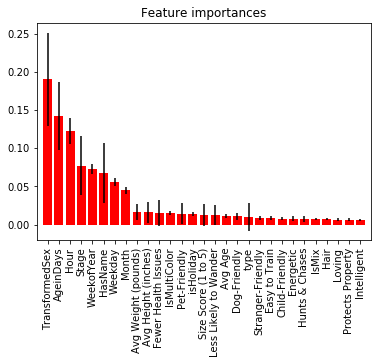


Fold 2 of 8
Train log loss: 4.8282511162
Test log loss: 10.6604032158
                 precision    recall  f1-score   support

       Adoption       0.70      0.85      0.77      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.64      0.20      0.30       172
Return_to_owner       0.51      0.47      0.49       535
       Transfer       0.77      0.72      0.75      1048

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.691349713901


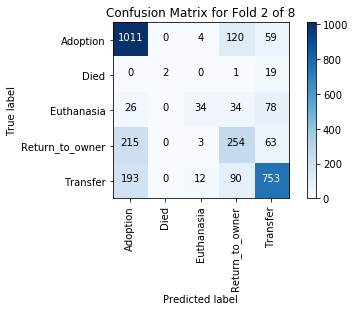

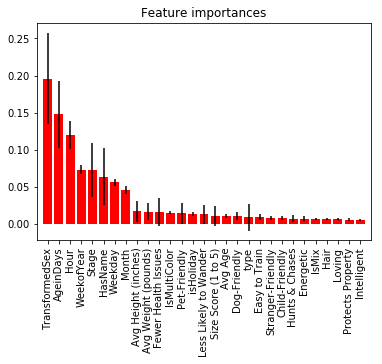


Fold 3 of 8
Train log loss: 4.94099384282
Test log loss: 10.5128127478
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.60      0.15      0.24       172
Return_to_owner       0.53      0.50      0.52       535
       Transfer       0.76      0.73      0.75      1047

    avg / total       0.69      0.70      0.68      2970

Classifier score (accuracy): 0.695622895623


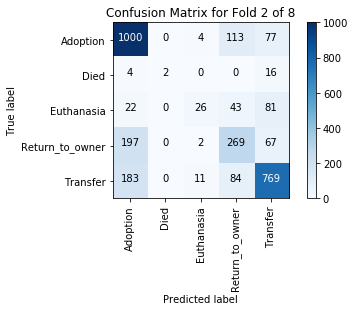

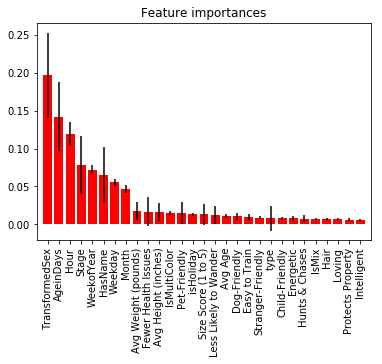


Fold 4 of 8
Train log loss: 4.7133824923
Test log loss: 10.5593296184
                 precision    recall  f1-score   support

       Adoption       0.70      0.86      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.57      0.16      0.25       172
Return_to_owner       0.53      0.44      0.48       535
       Transfer       0.76      0.74      0.75      1047

    avg / total       0.68      0.69      0.68      2970

Classifier score (accuracy): 0.694276094276


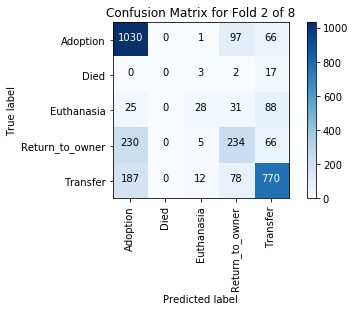

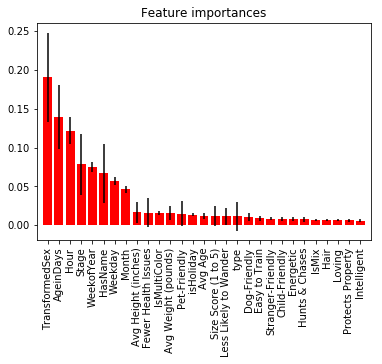


Fold 5 of 8
Train log loss: 4.78149975778
Test log loss: 11.2454534592
                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76      1194
           Died       0.50      0.05      0.08        22
     Euthanasia       0.53      0.14      0.22       172
Return_to_owner       0.46      0.44      0.45       535
       Transfer       0.76      0.71      0.74      1047

    avg / total       0.67      0.67      0.66      2970

Classifier score (accuracy): 0.674410774411


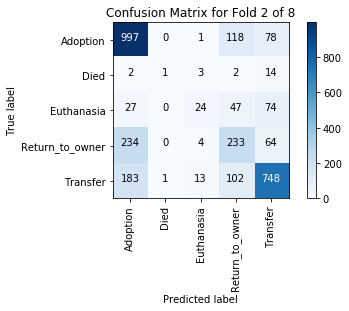

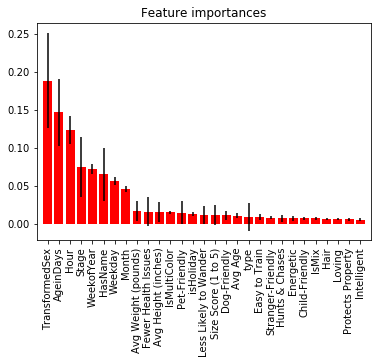


Fold 6 of 8
Train log loss: 4.73498064965
Test log loss: 10.5128127478
                 precision    recall  f1-score   support

       Adoption       0.70      0.85      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.69      0.20      0.31       172
Return_to_owner       0.52      0.48      0.50       535
       Transfer       0.78      0.73      0.75      1047

    avg / total       0.69      0.70      0.68      2970

Classifier score (accuracy): 0.695622895623


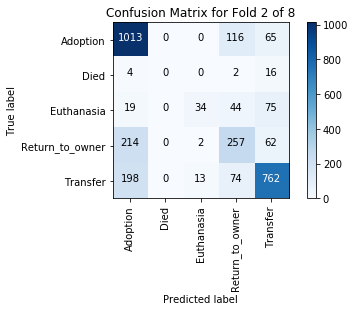

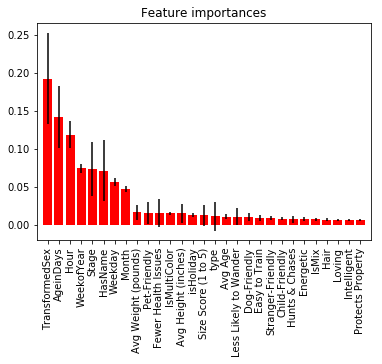


Fold 7 of 8
Train log loss: 4.76276619327
Test log loss: 10.6479044479
                 precision    recall  f1-score   support

       Adoption       0.70      0.84      0.77      1193
           Died       0.00      0.00      0.00        21
     Euthanasia       0.68      0.17      0.28       172
Return_to_owner       0.51      0.50      0.50       535
       Transfer       0.78      0.72      0.74      1047

    avg / total       0.69      0.69      0.68      2968

Classifier score (accuracy): 0.691711590296


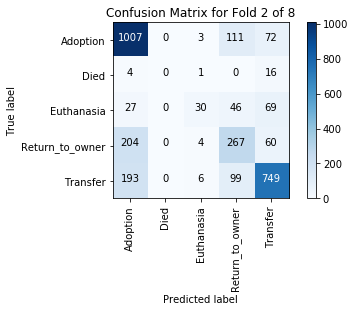

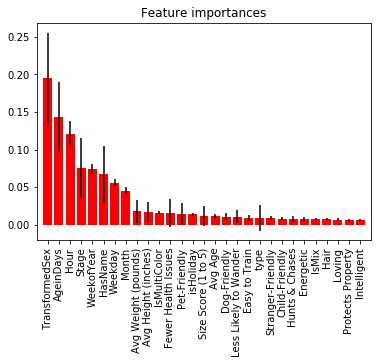


Fold 8 of 8
Train log loss: 4.80097464197
Test log loss: 10.7177267721
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.76      1193
           Died       0.67      0.10      0.17        21
     Euthanasia       0.69      0.18      0.29       172
Return_to_owner       0.51      0.51      0.51       535
       Transfer       0.76      0.72      0.74      1047

    avg / total       0.69      0.69      0.68      2968

Classifier score (accuracy): 0.689690026954


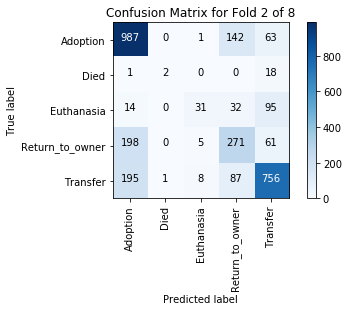

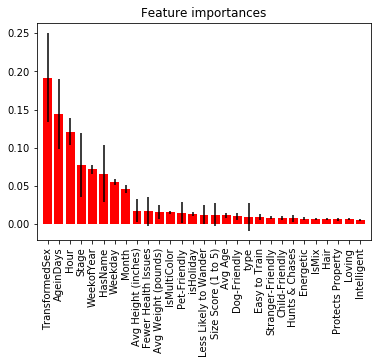

Avg. train log loss: 4.80265501263 std: 0.0684563974162
Avg. test log loss: 10.6339557989 std: 0.272055813755


In [365]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                             random_state=8, max_features='auto', n_jobs= -1)  
loss = TrainTest([], [])
clfs = run_classifier_CV(rf_clf, train, test, target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))
    


Test log loss: 11.0128691064
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.76      1219
           Died       1.00      0.04      0.08        23
     Euthanasia       0.57      0.13      0.21       178
Return_to_owner       0.47      0.49      0.48       506
       Transfer       0.76      0.71      0.74      1044

    avg / total       0.68      0.68      0.67      2970

Without Soft Voting on Folds:

Test log loss: 11.1407905004
                 precision    recall  f1-score   support

       Adoption       0.71      0.82      0.76      1219
           Died       0.50      0.04      0.08        23
     Euthanasia       0.51      0.12      0.20       178
Return_to_owner       0.47      0.48      0.47       506
       Transfer       0.75      0.71      0.73      1044

    avg / total       0.67      0.68      0.66      2970



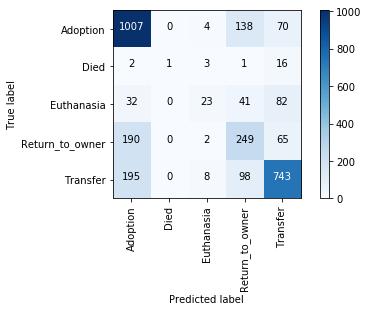

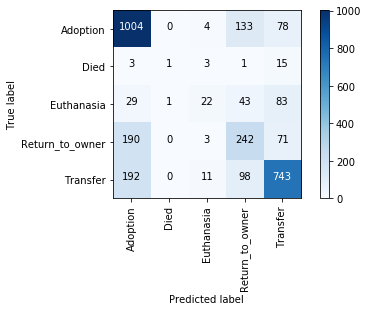

In [366]:
X = TrainTest(data.iloc[:, 1:-1], validate.iloc[:,1:-1])
t = TrainTest(data.OutcomeType, validate.OutcomeType)
preds = average([clfs[i].predict_proba(X.test) for i in range(n_splits)], axis=0)
pred = TrainTest(None, [target_names[argmax(preds[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred.test, target_names)])

plot_results(X, t, target_names, loss, pred, 1, show_title=False)


print("Without Soft Voting on Folds:")
rf_clf.fit(X.train, t.train)
pred = TrainTest(None, rf_clf.predict(X.test))
loss = TrainTest(None, [calc_ln_loss(t.test, pred.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)


Fold 1 of 8
Train log loss: 12.5447520942
Test log loss: 12.6556956575
                 precision    recall  f1-score   support

       Adoption       0.63      0.80      0.71      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       1.00      0.06      0.12       173
Return_to_owner       0.48      0.35      0.41       535
       Transfer       0.69      0.69      0.69      1048

    avg / total       0.64      0.63      0.61      2972

Classifier score (accuracy): 0.633580080754

Fold 2 of 8
Train log loss: 12.4760280907
Test log loss: 12.5437023662
                 precision    recall  f1-score   support

       Adoption       0.63      0.81      0.71      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.72      0.10      0.18       172
Return_to_owner       0.50      0.35      0.41       535
       Transfer       0.69      0.69      0.69      1048

    avg / total       0.63      0.64      0.61      2971

Classifi

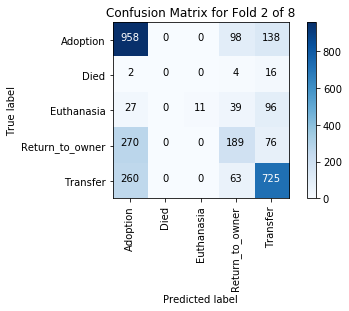

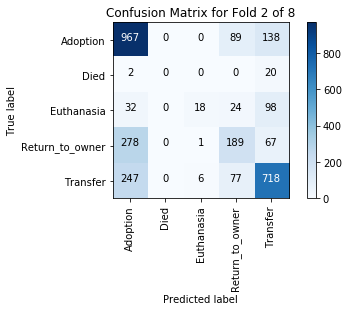

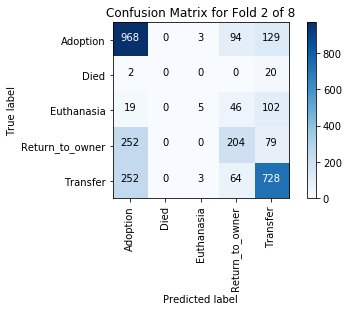

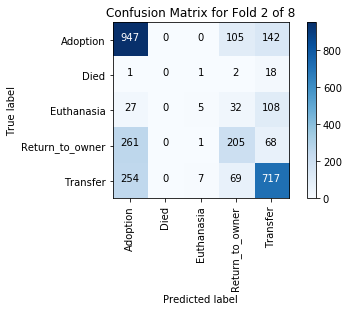

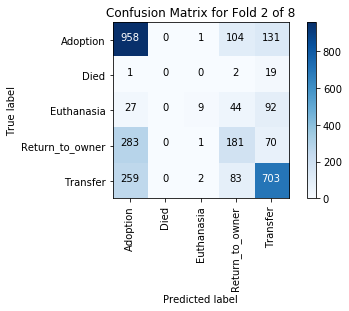

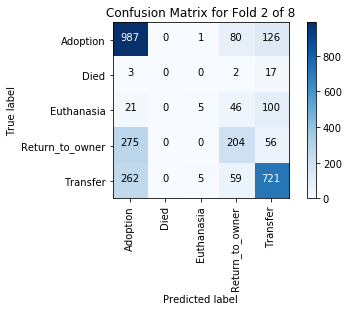

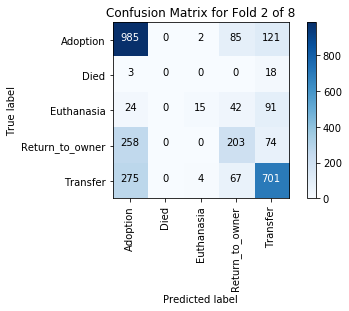

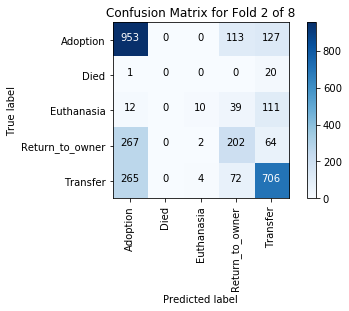

In [367]:
lr_clf = LogisticRegression()
loss = TrainTest([], [])
clfs = run_classifier_CV(lr_clf, train, test, target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))

In [368]:
voting_clf = VotingClassifier([('rf', rf_clf), ('lr', lr_clf)], voting='soft')

# score using cross validation
clf_list = [rf_clf, lr_clf, voting_clf]
name_list = ['Random Forest', 'Logistic Regression', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = cross_val_score(clf, X.train, t.train, scoring=ln_loss_scorer, cv=skf_generator(data, n_splits))
    print("Log Loss: %0.2f +/- %0.2f (%s 95%% CI)" % (scores.mean(), scores.std()*1.96, name))

Log Loss: 10.63 +/- 0.53 (Random Forest 95% CI)
Log Loss: 12.59 +/- 0.46 (Logistic Regression 95% CI)
Log Loss: 11.09 +/- 0.59 (Ensemble 95% CI)


In [369]:
def plot_hypervariable(result, loss, variable):
    columns = ['count', 'train', 'test']
    loss = pd.DataFrame(result, columns=columns)
    loss = pd.melt(loss, id_vars=['count'], value_vars=columns[1:])

    (ggplot(loss, aes(x='count', y='value', color='variable'))
     + geom_line(size=1)
     + theme_seaborn()
     + theme(panel_grid_minor = element_line(size=0.5))
     + ylab('Log Loss')
     + xlab(variable)
    ).draw().set_size_inches(4, 4)

In [370]:
# Takes a while. Only run if needed, and use as many processes as needed

# def iteration(i):
#     try:
#         clf = RandomForestClassifier(n_estimators=100, max_depth=i, 
#                                      random_state=8, max_features='auto')
#         loss = TrainTest([], [])
#         run_classifier_CV(clf, train, test, target_names, loss)
#         return (i, sum(loss.train) / n_splits, sum(loss.test) / n_splits)
#     except:
#         import traceback
#         traceback.print_exc()

# range_ = range(2, 30)
# p = Pool(processes=8)
# result = p.map(iteration, range_)
# p.close()
# p.join()

# plot_hypervariable(result, loss, 'Max Depth')


In [371]:
# remove cat/dog specific fields:
animals = animals.iloc[:, range(0, 10) + [26, 28, 29, 30]] 
data, validate = train_test_split(animals, test_size=1./(n_splits+1), random_state=8)
train, test = run_skf(data, n_splits=n_splits)


Fold 1 of 8
Train log loss: 4.49617207508
Test log loss: 10.319795908
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.77      1194
           Died       0.00      0.00      0.00        22
     Euthanasia       0.63      0.23      0.33       173
Return_to_owner       0.53      0.52      0.52       535
       Transfer       0.76      0.76      0.76      1048

    avg / total       0.69      0.70      0.69      2972

Classifier score (accuracy): 0.701211305518


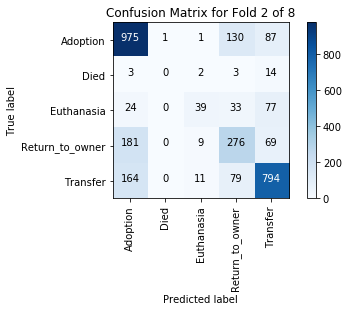

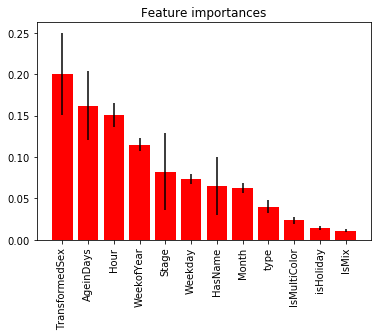


Fold 2 of 8
Train log loss: 4.51423203122
Test log loss: 10.6487779124
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.77      1194
           Died       1.00      0.09      0.17        22
     Euthanasia       0.66      0.27      0.38       172
Return_to_owner       0.50      0.47      0.49       535
       Transfer       0.76      0.73      0.74      1048

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.691686300909


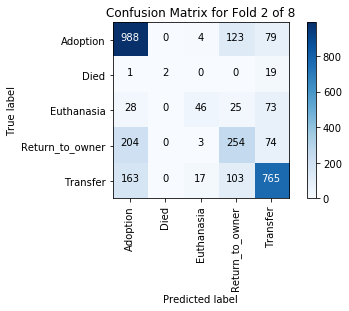

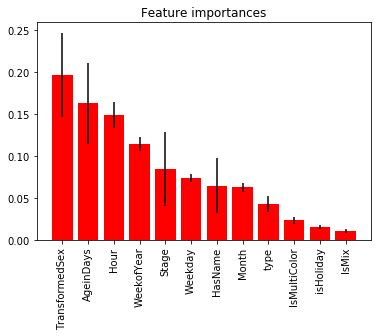


Fold 3 of 8
Train log loss: 4.47912555489
Test log loss: 10.2220823068
                 precision    recall  f1-score   support

       Adoption       0.74      0.82      0.78      1194
           Died       1.00      0.18      0.31        22
     Euthanasia       0.54      0.20      0.30       172
Return_to_owner       0.52      0.52      0.52       535
       Transfer       0.77      0.76      0.76      1047

    avg / total       0.70      0.70      0.69      2970

Classifier score (accuracy): 0.70404040404


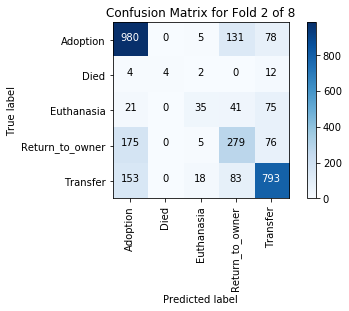

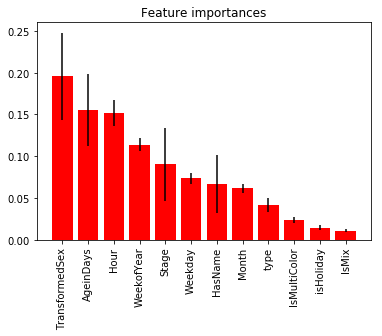


Fold 4 of 8
Train log loss: 4.35452080096
Test log loss: 10.9314645829
                 precision    recall  f1-score   support

       Adoption       0.71      0.82      0.76      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.47      0.16      0.23       172
Return_to_owner       0.50      0.45      0.48       535
       Transfer       0.74      0.74      0.74      1047

    avg / total       0.67      0.68      0.67      2970

Classifier score (accuracy): 0.683501683502


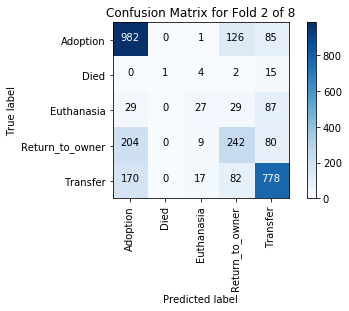

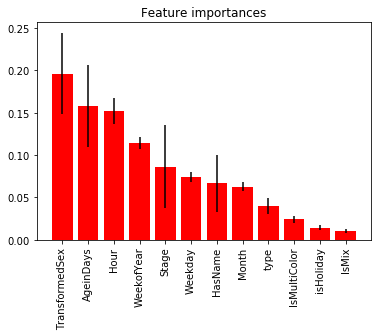


Fold 5 of 8
Train log loss: 4.34787521408
Test log loss: 11.1640489357
                 precision    recall  f1-score   support

       Adoption       0.70      0.82      0.75      1194
           Died       0.50      0.14      0.21        22
     Euthanasia       0.52      0.19      0.28       172
Return_to_owner       0.47      0.44      0.45       535
       Transfer       0.77      0.72      0.74      1047

    avg / total       0.67      0.68      0.67      2970

Classifier score (accuracy): 0.676767676768


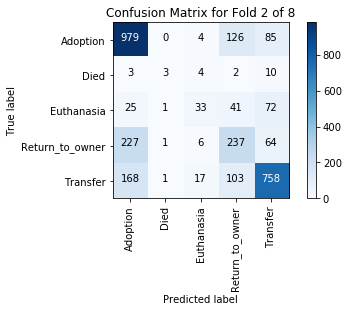

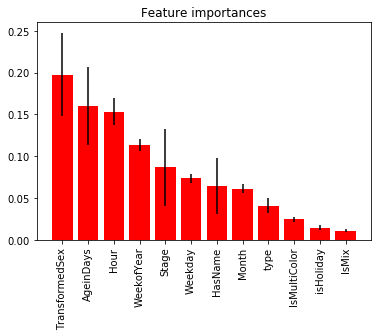


Fold 6 of 8
Train log loss: 4.4276222566
Test log loss: 10.5942172713
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.77      1194
           Died       1.00      0.05      0.09        22
     Euthanasia       0.61      0.22      0.32       172
Return_to_owner       0.52      0.49      0.50       535
       Transfer       0.76      0.73      0.75      1047

    avg / total       0.69      0.69      0.68      2970

Classifier score (accuracy): 0.693265993266


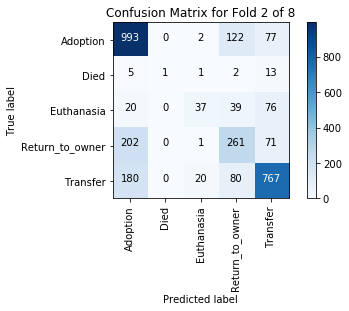

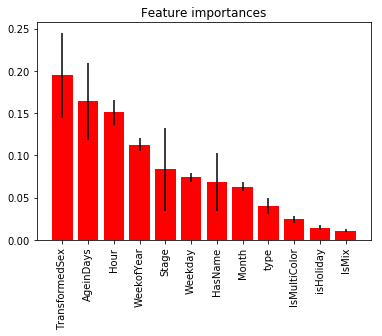


Fold 7 of 8
Train log loss: 4.49198457851
Test log loss: 11.0319272313
                 precision    recall  f1-score   support

       Adoption       0.70      0.82      0.76      1193
           Died       0.00      0.00      0.00        21
     Euthanasia       0.52      0.17      0.25       172
Return_to_owner       0.50      0.50      0.50       535
       Transfer       0.76      0.71      0.74      1047

    avg / total       0.67      0.68      0.67      2968

Classifier score (accuracy): 0.680592991914


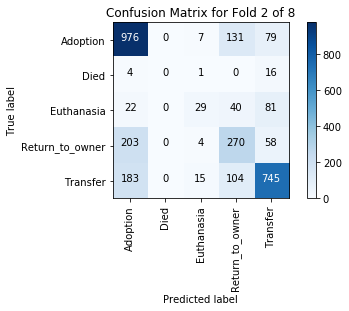

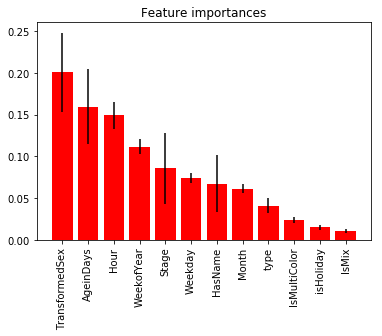


Fold 8 of 8
Train log loss: 4.4537761298
Test log loss: 10.7875490964
                 precision    recall  f1-score   support

       Adoption       0.72      0.82      0.76      1193
           Died       0.67      0.10      0.17        21
     Euthanasia       0.54      0.17      0.26       172
Return_to_owner       0.50      0.52      0.51       535
       Transfer       0.76      0.72      0.74      1047

    avg / total       0.68      0.69      0.68      2968

Classifier score (accuracy): 0.687668463612


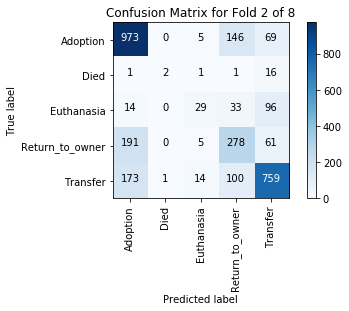

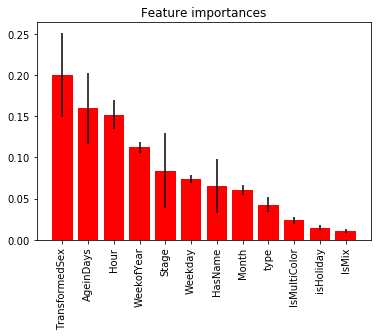

Avg. train log loss: 4.44566358014 std: 0.0599780717641
Avg. test log loss: 10.7124829056 std: 0.310701902262


In [372]:
clf = RandomForestClassifier(n_estimators=100, max_depth=15, 
                             random_state=8, max_features='auto', n_jobs= -1)  
loss = TrainTest([], [])
run_classifier_CV(clf, train, test, target_names, loss, plot=True)
print('Avg. train log loss: {} std: {}'.format(mean(loss.train), std(loss.train)))
print('Avg. test log loss: {} std: {}'.format(mean(loss.test), std(loss.test)))

# TODO

* Try changing TransformedSex to not umpute Unknowns (and just just change the one NaN to an unknown). I think this will improve the results.